# XGBoost to predict discharge disability: Predicted outcome for hypothetical patients (with and without thrombolysis)
Using 1 k-fold

### Plain English summary

Use the model trained in notebook 040 to show the multiclass mRS distributions (individual mRS + cumulative distributions) for hypothetical patients with/without thrombolysis. 

Patient examples:
* Someone similar to clinical trial: no prior disability, age 72.5, no afib diagnosis, NIHSS 15, precise onset time
* As #1 but mild stroke
* As #1 but severe stroke
* As #1 but prior mRS 3 or 4
* As #1 but with afib
* As #1 but age 87.5
* As #1 but imprecise onset time


Assume the onset to treatment time is 2 hours.
Set patients as going to the hospital that has the most neutral contribution towards use of thrombolysis: Royal Lancaster Infirmary.

### Model and data
Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split

### Aims

### Observations


#### Further work

#### Resources


## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass

import pickle

from os.path import exists

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

In [3]:
surrogate_time_for_no_thrombolysis = 9999

Select the features for the model

In [4]:
input_features = ["prior_disability", "stroke_severity", "stroke_team", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(input_features)
target_feature = 'discharge_disability'

# Set the default onset to treatment time as 2 hours
ott_default = 120 

Create dictionary storing the feature names to use in the plots

In [5]:
dict_feature_names = {}
dict_feature_names["prior_disability"] = "Prior disability (mRS)"
dict_feature_names["stroke_severity"] = "Stroke severity (NIHSS)"
dict_feature_names["stroke_team"] = "Stroke team"
dict_feature_names["age"] = "Age (years)"
dict_feature_names["onset_to_thrombolysis_time"] = "Onset to thrombolysis time (minutes)"
dict_feature_names["any_afib_diagnosis"] = "Atrial fibrilation diagnosis"
dict_feature_names["precise_onset_known"] = "Precise onset time known"
dict_feature_names['discharge_disability'] = "Discharge disabiliity (mRS)"

Set kfold to use

In [6]:
k = 0

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [7]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_mrs_distributions'
    notebook: str = '060_'

paths = Paths()

Create output folders if needed

In [8]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [9]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)
# Remove thrombectomy patients
mask = train["thrombectomy"] == 0
train = train[mask]
# Keep columns for model
train = train[input_features + [target_feature]]

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)
# Remove thrombectomy patients
mask = test["thrombectomy"] == 0
test = test[mask]
# Keep columns for model
test = test[input_features + [target_feature]]

Get list of features

In [10]:
feature_names = list(train)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [11]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [12]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [13]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in input_features + [target_feature]:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [14]:
feature_names_ohe = list(train)
feature_names_ohe.remove(target_feature)
n_features = len(feature_names_ohe)

print(f"There are {len(feature_names)} original features (before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 117 features (after one-hot encoding)


Extract the team names

In [15]:
ohe_stroke_team_features = [col for col in feature_names_ohe if col.startswith('team')]

Create dataframe of the key patient prototypes (user defines the patients).

The values for feature "onset_to_thrombolysis_time" is set later, use these values for the two scenarios:
* Not receive thrombolysis: 9999
* Receive thrombolysis: 120

In [16]:
team_attend_name = "Royal Lancaster Infirmary"

# Read in training set, restrict to chosen features & store
filename = os.path.join('../data_processing/output/02_team_code.csv')
team_code = pd.read_csv(filename)
team_attend_code = team_code["team_code"][team_code["stroke_team"]==team_attend_name]
team_attend_code = f"team_{team_attend_code.values[0]}"

In [134]:
stroke_severity = ['15', '1', '40', '15', '15', '15', '15', '15']
prior_disability = ['1', '1', '1', '3', '4', '1', '1', '1']
any_afib_diagnosis = ['0', '0', '0', '0', '1', '0', '0', '0']
age = ['72.5','72.5','72.5','72.5','72.5','72.5', '87.5', '72.5']
precise_onset_known = ['1', '1', '1', '1', '1', '1', '1', '0']

list_index = ['Ideal', 'Mild stroke (NIHSS 1)', 'Severe stroke (NIHSS 40)', 
              'Prior disability (mRS 3)', 'Prior disability (mRS 4)', 'Atrial fibrillation diagnosis', 
              'Older (87.5 years)', 'Imprecise onset time']

df_patient_prototypes = pd.DataFrame(columns=feature_names_ohe)
df_patient_prototypes["prior_disability"] = prior_disability
df_patient_prototypes["stroke_severity"] = stroke_severity
df_patient_prototypes["age"] = age
df_patient_prototypes["any_afib_diagnosis"] = any_afib_diagnosis
df_patient_prototypes["precise_onset_known"] = precise_onset_known
df_patient_prototypes["index"] = list_index

# Set not attend all hosptials (afterwards set to attend one of them)
for col in ohe_stroke_team_features:
    df_patient_prototypes[col] = ['0', '0', '0', '0', '0', '0', '0', '0']

# Set patients as going to the specified team
team_attend_code = 'team_40'
df_patient_prototypes[team_attend_code] = ['1', '1', '1', '1', '1', '1', '1', '1']

df_patient_prototypes.set_index("index", inplace=True)

n_patients = df_patient_prototypes.shape[0]

df_patient_prototypes

,prior_disability,stroke_severity,age,onset_to_thrombolysis_time,any_afib_diagnosis,precise_onset_known,team_1,team_2,team_3,team_4,...,team_108,team_109,team_110,team_111,team_112,team_113,team_114,team_116,team_117,team_118
index,,,,,,,,,,,,,,,,,,,,,
Ideal,1,15,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mild stroke (NIHSS 1),1,1,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Severe stroke (NIHSS 40),1,40,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Prior disability (mRS 3),3,15,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Prior disability (mRS 4),4,15,72.5,NaN,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atrial fibrillation diagnosis,1,15,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Older (87.5 years),1,15,87.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Imprecise onset time,1,15,72.5,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load XGBoost model

Load model trained in notebook 040 on 7 features.

In [18]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

In [20]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                (f'040_xgb_7_features_5fold_{k}.p'))

model = load_xgboost_model(filename)

Plot (want to create a subplot per patient, with the two mRS probability distributions on the same plot)

In [21]:
def create_df_for_bar_plot(df):
    """ 
    
    Args:
        df [dataframe]:
    
    Return:
        df_bar [dataframe]: 
    
    """
    df_bar  = pd.DataFrame()
    df_bar["Treatment"] = (["With thrombolysis"] * 7) + (["No thrombolysis"] * 7)
    df_bar["Discharge disability"] = np.append(df.index.values, df.index.values)
    df_bar["Probability"] = np.append(df["with"], df["without"])
    return(df_bar)

For each patient prototype, set up a dataframe containing two of these patients, one getting IVT, and one not.

Use the XGBoost model to predict the probability of being in each discharge disability.

Plot result in a bar plot. A plot per patient.

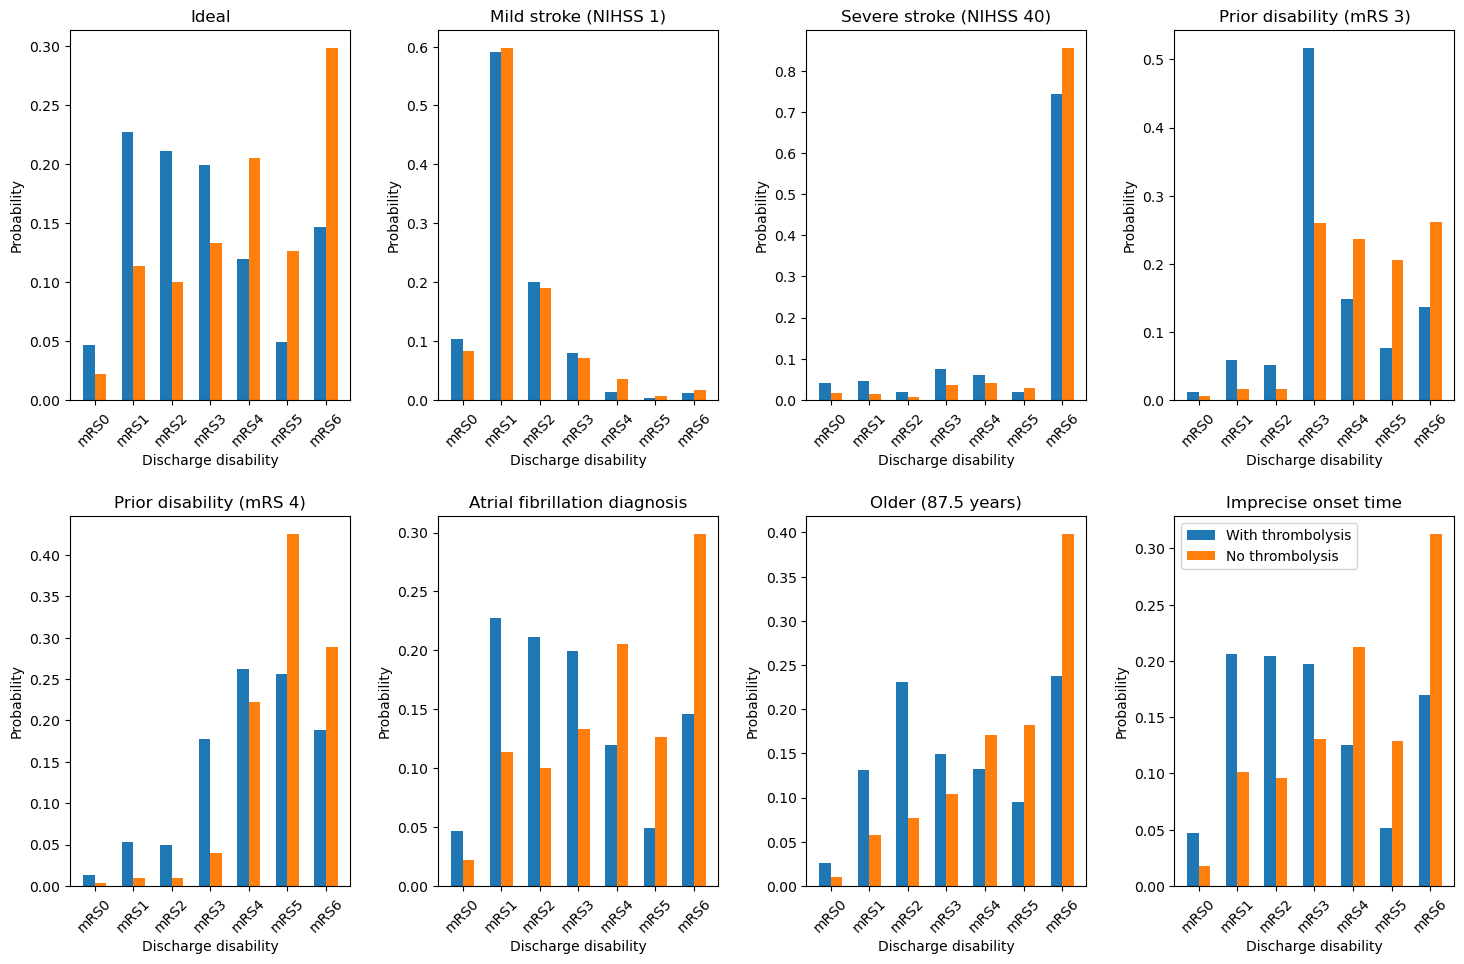

In [26]:
list_get_treatment = ["With thrombolysis", "No thrombolysis"]
list_onset_to_thrombolysis_time = [ott_default, 
                                   surrogate_time_for_no_thrombolysis]

columns=["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5","mRS6"]
index=["with","without"]

# Position of bars on x-axis
ind = np.arange(len(columns))

width = 0.3

fig = plt.figure(figsize=(15, 10))

for patient_loc in range(n_patients):
#    title = df_patient_prototypes.index.values[patient_loc]
    title = df_patient_prototypes.index[patient_loc]
    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), 
                                      index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[patient_loc,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[patient_loc,:]

    # make first copy have, and the second copy not have thrombolysis treatment 
    # (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = (
                                            list_onset_to_thrombolysis_time)

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)

    df_patient_mrs_results = pd.DataFrame(data=y_probs, columns=columns, 
                                          index=index)

    df_patient_mrs_results = df_patient_mrs_results.T

    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

    ax1 = fig.add_subplot(2,4,patient_loc+1)
    # Plotting
    mask = df_bar["Treatment"] == list_get_treatment[0]
    ax1.bar(ind, df_bar[mask]["Probability"].values, width, 
            label=list_get_treatment[0])
    
    mask = df_bar["Treatment"] == list_get_treatment[1]
    ax1.bar(ind + width, df_bar[mask]["Probability"].values, width, 
            label=list_get_treatment[1])

    plt.xlabel("Discharge disability")
    plt.ylabel("Probability")
    plt.title(title)
    plt.xticks(ind + width / 2, columns, rotation=45)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_bar_plot.jpg'))

plt.savefig(filename, dpi=300)

plt.show()


Include the two criteria for a better outcome with treatment: on average reduce disability, without increasing the risk of death and the severest disability.

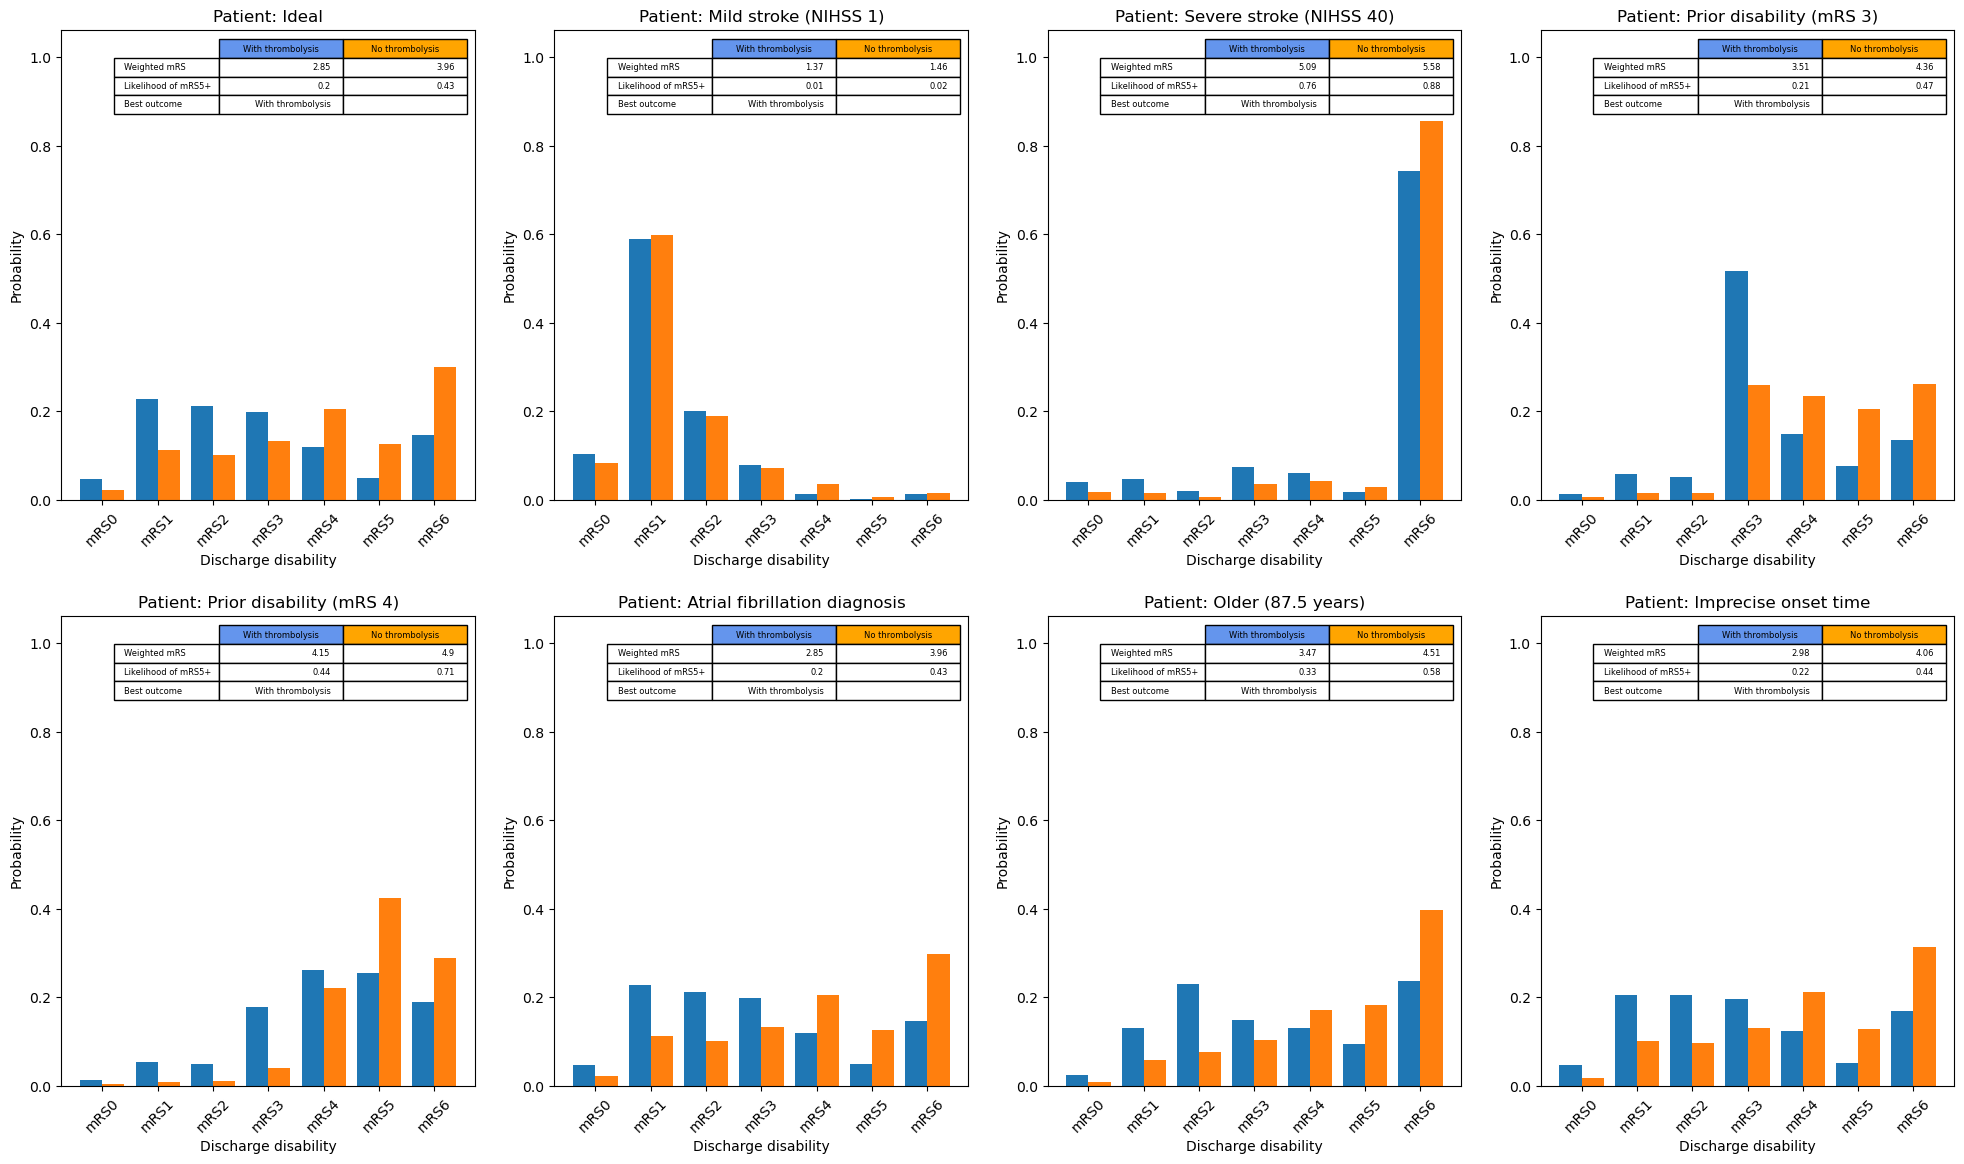

In [27]:
list_get_treatment = ["With thrombolysis","No thrombolysis"]
list_onset_to_thrombolysis_time = [ott_default, 
                                   surrogate_time_for_no_thrombolysis]

columns=["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5","mRS6"]
index=["with","without"]

# Position of bars on x-axis
ind = np.arange(len(columns))

width = 0.4

# Initialise, so overwrite with a larger number
y_probs_max = 0
fig = plt.figure(figsize=(20, 12))

for patient_loc in range(n_patients):
#    title = df_patient_prototypes.index.values[patient_loc]

    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), 
                                      index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[patient_loc,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[patient_loc,:]

    # make first copy have, and the second copy not have thrombolysis treatment 
    # (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = (
                                            list_onset_to_thrombolysis_time)

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)
    y_probs_max = max(y_probs.max(), y_probs_max)
    df_patient_mrs_results = pd.DataFrame(data=y_probs, columns=columns, 
                                          index=index)

    df_patient_mrs_results = df_patient_mrs_results.T
    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

    ax1 = fig.add_subplot(2,4,patient_loc+1)

    # Plotting
    c1 = []
    c2 = []
    adjust = 0
    for treatment_decision in list_get_treatment:
        mask = df_bar["Treatment"] == treatment_decision
        ax1.bar(ind + adjust, df_bar[mask]["Probability"].values, width, 
                label=treatment_decision)
        c1.append((df_bar[mask]["Probability"].values * np.arange(7)).sum())
        c2.append(df_bar[mask]["Probability"].values[-2:].sum())
        adjust += width

    plt.xlabel("Discharge disability")
    plt.ylabel("Probability")


    results_dataframe = pd.DataFrame(index=["Weighted mRS","Likelihood of mRS5+"])#columns=["With thrombolysis", "No thrombolysis"])
    results_dataframe["With thrombolysis"] = [round(c1[0],2), round(c2[0],2)]
    results_dataframe["No thrombolysis"] = [round(c1[1],2), round(c2[1],2)]

#    result_text = "Result: Not have a better outcome with treatment"
    if (c1[0] < c1[1]) and (c2[0] < c2[1]):
        result_list = ["With thrombolysis", ""]
#        result_text = "Result: Have a better outcome with treatment"
    else:
        result_list = ["Not with thrombolysis", ""]


    title = f"Patient: {df_patient_prototypes.index[patient_loc]}"#\n\n{result_text}"


#    result_title = (f"{result_text}\n\n"
#        f"Weighted mRS:\n{c1[0]:.2f} with treatment, vs. {c1[1]:.2f} without\n\n"
#        f"Likelihood of mRS5+:\n{c2[0]:.2f} with treatment, vs. {c2[1]:.2f} without")
#    result_text = "Not have a better outcome with treatment"
#    if (c1[0] < c1[1]) and (c2[0] < c2[1]):
#        result_text = "Have a better outcome with treatment"

#    title = (f"Patient: {df_patient_prototypes.index[patient_loc]}\n"
#        f"{result_text}\n\n"
#        f"Weighted mRS:\n{c1[0]:.2f} with treatment, vs. {c1[1]:.2f} without\n\n"
#        f"Likelihood of mRS5+:\n{c2[0]:.2f} with treatment, vs. {c2[1]:.2f} without")

    plt.title(title)
    plt.xticks(ind + width / 2, columns, rotation=45)

#    table(ax1, results_dataframe, loc='bottom') 


    my_table = plt.table(cellText=[[round(c1[0],2), round(c1[1],2)], [round(c2[0],2), round(c2[1],2)],result_list],
                        colWidths=[0.3] * 3,
                        rowLabels=["Weighted mRS","Likelihood of mRS5+","Best outcome"],
                        colLabels=["With thrombolysis", "No thrombolysis"],
                        colColours=["cornflowerblue", "orange"],
                        loc='upper right')

axs = fig.axes
for patient_loc in range(n_patients):
    ax1 = axs[patient_loc]
    ax1.set_ylim(0, (y_probs_max * 1.24))


# Finding the best position for legends and putting it
#plt.legend(loc='best', bbox_to_anchor=[1, 0.5])
plt.tight_layout(pad=2)



filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_bar_plot.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

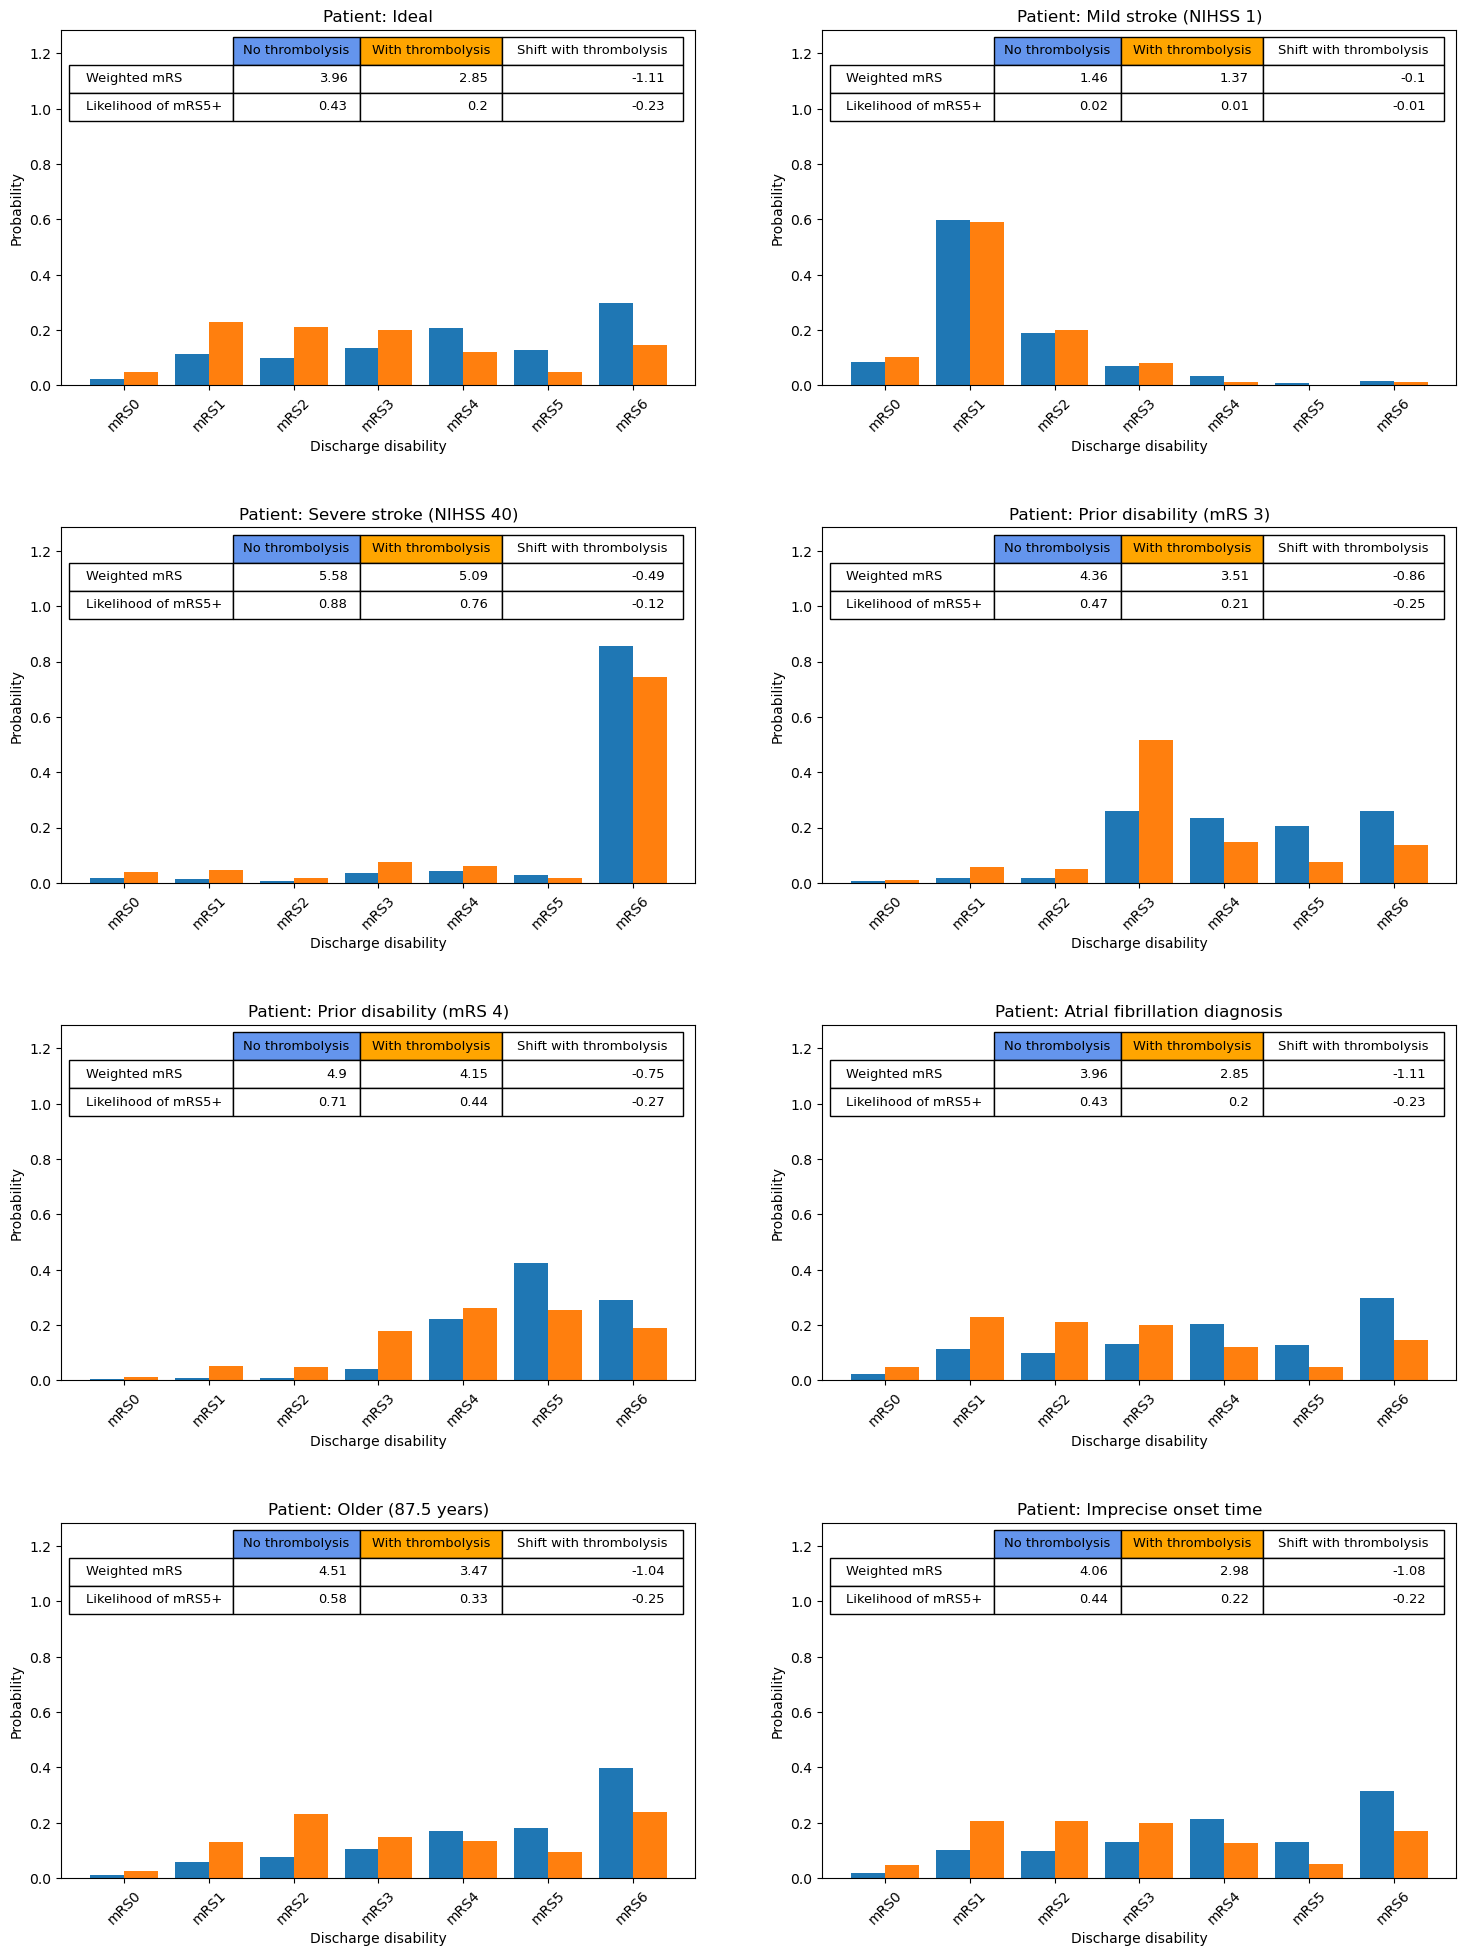

In [106]:
list_get_treatment = ["No thrombolysis", "With thrombolysis"]
list_onset_to_thrombolysis_time = [9999, ott_default]

columns=["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5","mRS6"]
index=["without","with"]

# Position of bars on x-axis
ind = np.arange(len(columns))

width = 0.4

# Initialise, so overwrite with a larger number
y_probs_max = 0
fig = plt.figure(figsize=(18, 24))

for patient_loc in range(n_patients):
#    title = df_patient_prototypes.index.values[patient_loc]

    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), 
                                      index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[patient_loc,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[patient_loc,:]

    # make first copy have, and the second copy not have thrombolysis treatment 
    # (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = (
                                            list_onset_to_thrombolysis_time)

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)
    y_probs_max = max(y_probs.max(), y_probs_max)
    df_patient_mrs_results = pd.DataFrame(data=y_probs, columns=columns, 
                                          index=index)

    df_patient_mrs_results = df_patient_mrs_results.T
    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

    ax1 = fig.add_subplot(4,2,patient_loc+1)

    # Plotting
    c1 = []
    c2 = []
    adjust = 0
    for treatment_decision in list_get_treatment:
        mask = df_bar["Treatment"] == treatment_decision
        ax1.bar(ind + adjust, df_bar[mask]["Probability"].values, width, 
                label=treatment_decision)
        c1.append((df_bar[mask]["Probability"].values * np.arange(7)).sum())
        c2.append(df_bar[mask]["Probability"].values[-2:].sum())
        adjust += width

    plt.xlabel("Discharge disability", fontsize=10)
    plt.ylabel("Probability", fontsize=10)


    results_dataframe = pd.DataFrame(index=["Weighted mRS","Likelihood of mRS5+"])#columns=["With thrombolysis", "No thrombolysis"])
    results_dataframe["No thrombolysis"] = [round(c1[1],2), round(c2[1],2)]
    results_dataframe["With thrombolysis"] = [round(c1[0],2), round(c2[0],2)]

#    result_text = "Result: Not have a better outcome with treatment"
    if (c1[0] < c1[1]) and (c2[0] < c2[1]):
        result_list = [u'\u2713',"",""]
#        result_text = "Result: Have a better outcome with treatment"
    else:
        result_list = ["", u'\u2713', ""]


    title = f"Patient: {df_patient_prototypes.index[patient_loc]}"#\n\n{result_text}"


#    result_title = (f"{result_text}\n\n"
#        f"Weighted mRS:\n{c1[0]:.2f} with treatment, vs. {c1[1]:.2f} without\n\n"
#        f"Likelihood of mRS5+:\n{c2[0]:.2f} with treatment, vs. {c2[1]:.2f} without")
#    result_text = "Not have a better outcome with treatment"
#    if (c1[0] < c1[1]) and (c2[0] < c2[1]):
#        result_text = "Have a better outcome with treatment"

#    title = (f"Patient: {df_patient_prototypes.index[patient_loc]}\n"
#        f"{result_text}\n\n"
#        f"Weighted mRS:\n{c1[0]:.2f} with treatment, vs. {c1[1]:.2f} without\n\n"
#        f"Likelihood of mRS5+:\n{c2[0]:.2f} with treatment, vs. {c2[1]:.2f} without")

    plt.title(title)
    plt.xticks(ind + width / 2, columns, rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
#    x_ticks = ax1.xaxis.get_major_ticks()
#    x_ticks[-1].label1.set_visible(False) ## set last x tick label invisible
#    y_ticks = ax1.yaxis.get_major_ticks()
#    y_ticks[-1].label1.set_visible(False) ## set last y tick label invisible

#    table(ax1, results_dataframe, loc='bottom') 


    table = plt.table(cellText=[[round(c1[0],2), round(c1[1],2), round(c1[1]-c1[0],2)], [round(c2[0],2), round(c2[1],2), round(c2[1]-c2[0],2)]],#,result_list],
                      colWidths=[0.25] * 4,
                      rowLabels=["Weighted mRS","Likelihood of mRS5+"],#,"Model decision"],
                      colLabels=["No thrombolysis", "With thrombolysis", "Shift with thrombolysis"],
                      colColours=["cornflowerblue", "orange", "white"],
                      loc='upper right')
    table.auto_set_font_size(False)
    table.set_fontsize(9.4)
    table.scale(1, 1.9)
    table.auto_set_column_width(col=list(range(4)))
axs = fig.axes
for patient_loc in range(n_patients):
    ax1 = axs[patient_loc]
    ax1.set_ylim(0, (y_probs_max * 1.5))#1.24))
    plt.setp(ax1.get_yticklabels()[-1], visible=False)


# Finding the best position for legends and putting it
#plt.legend(loc='best', bbox_to_anchor=[1, 0.5])
#plt.tight_layout(pad=2)

plt.subplots_adjust(hspace=0.4)#None, hspace=None)#left=None, bottom=None, right=None, top=None, 

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_bar_plot_table.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

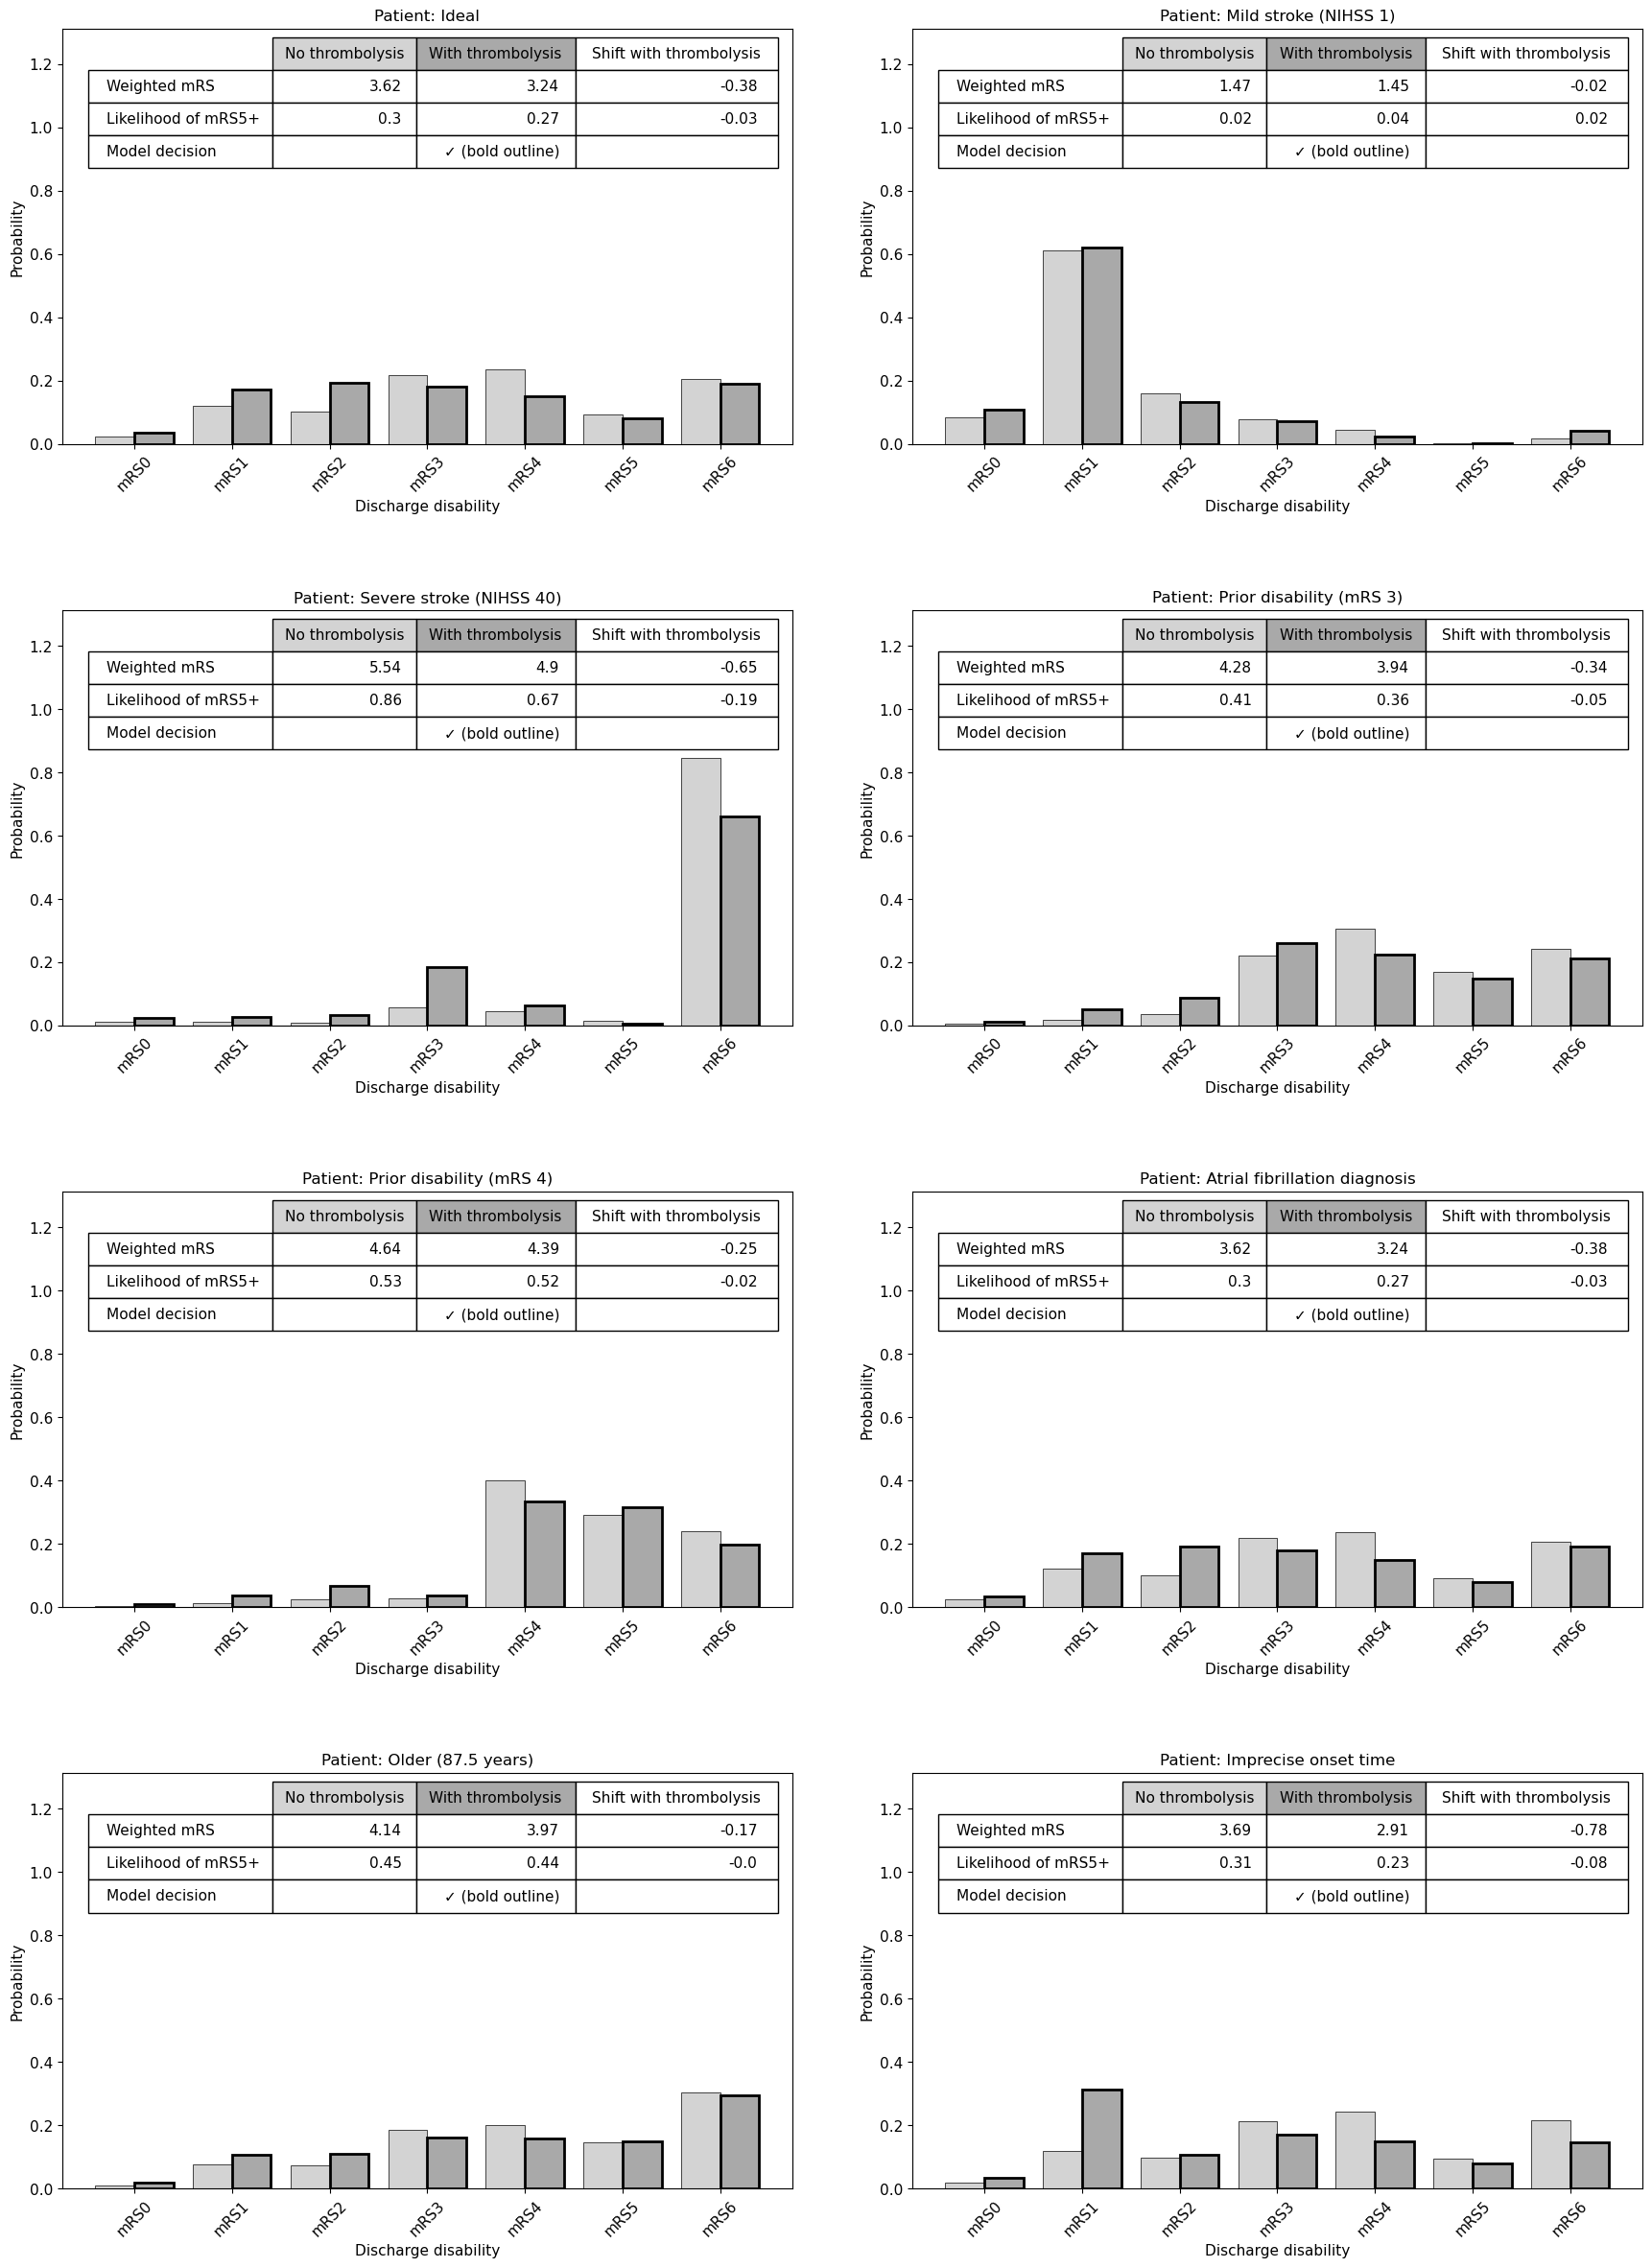

In [135]:
list_get_treatment = ["No thrombolysis", "With thrombolysis"]
list_onset_to_thrombolysis_time = [9999, ott_default]

columns=["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5","mRS6"]
index=["without","with"]

colours = ["lightgrey","darkgrey"]

# Position of bars on x-axis
ind = np.arange(len(columns))

width = 0.4

# Initialise, so overwrite with a larger number
y_probs_max = 0
fig = plt.figure(figsize=(18, 24))

for patient_loc in range(n_patients):
#    title = df_patient_prototypes.index.values[patient_loc]

    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), 
                                      index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[patient_loc,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[patient_loc,:]

    # make first copy have, and the second copy not have thrombolysis treatment 
    # (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = (
                                            list_onset_to_thrombolysis_time)

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)
    y_probs_max = max(y_probs.max(), y_probs_max)
    df_patient_mrs_results = pd.DataFrame(data=y_probs, columns=columns, 
                                          index=index)

    df_patient_mrs_results = df_patient_mrs_results.T
    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

    ax1 = fig.add_subplot(4,2,patient_loc+1)

    # Plotting
    c1 = []
    c2 = []
    adjust = 0
    for c,treatment_decision in enumerate(list_get_treatment):
        mask = df_bar["Treatment"] == treatment_decision
        ax1.bar(ind + adjust, df_bar[mask]["Probability"].values, width, 
                label=treatment_decision, color=colours[c], linewidth=0.5, edgecolor="k")
        c1.append((df_bar[mask]["Probability"].values * np.arange(7)).sum())
        c2.append(df_bar[mask]["Probability"].values[-2:].sum())
        adjust += width

    plt.xlabel("Discharge disability", fontsize=11)
    plt.ylabel("Probability", fontsize=11)


    results_dataframe = pd.DataFrame(index=["Weighted mRS","Likelihood of mRS5+"])#columns=["With thrombolysis", "No thrombolysis"])
    results_dataframe["No thrombolysis"] = [round(c1[1],2), round(c2[1],2)]
    results_dataframe["With thrombolysis"] = [round(c1[0],2), round(c2[0],2)]

#    result_text = "Result: Not have a better outcome with treatment"
    # Choose no treatment
    if (c1[0] < c1[1]) and (c2[0] < c2[1]):
        result_list = [u'\u2713' + " (bold outline)","",""]
        # put line around bars that are no treatment
        adjust = 0
        treatment_decision = list_get_treatment[0]
        mask = df_bar["Treatment"] == treatment_decision
        ax1.bar(ind + adjust, df_bar[mask]["Probability"].values, width, 
                label=treatment_decision, linewidth=2, edgecolor="k", color=colours[0])


#        result_text = "Result: Have a better outcome with treatment"
    # Choose treatment
    else:
        result_list = ["", u'\u2713' + " (bold outline)", ""]
        # put line around bars that are treatment
        adjust = width
        treatment_decision = list_get_treatment[1]
        mask = df_bar["Treatment"] == treatment_decision
        ax1.bar(ind + adjust, df_bar[mask]["Probability"].values, width, 
                label=treatment_decision, linewidth=2, edgecolor="k", color=colours[1])


    title = f"Patient: {df_patient_prototypes.index[patient_loc]}"#\n\n{result_text}"


#    result_title = (f"{result_text}\n\n"
#        f"Weighted mRS:\n{c1[0]:.2f} with treatment, vs. {c1[1]:.2f} without\n\n"
#        f"Likelihood of mRS5+:\n{c2[0]:.2f} with treatment, vs. {c2[1]:.2f} without")
#    result_text = "Not have a better outcome with treatment"
#    if (c1[0] < c1[1]) and (c2[0] < c2[1]):
#        result_text = "Have a better outcome with treatment"

#    title = (f"Patient: {df_patient_prototypes.index[patient_loc]}\n"
#        f"{result_text}\n\n"
#        f"Weighted mRS:\n{c1[0]:.2f} with treatment, vs. {c1[1]:.2f} without\n\n"
#        f"Likelihood of mRS5+:\n{c2[0]:.2f} with treatment, vs. {c2[1]:.2f} without")

    plt.title(title)
    plt.xticks(ind + width / 2, columns, rotation=45, fontsize=11)
    plt.yticks(fontsize=11)
#    x_ticks = ax1.xaxis.get_major_ticks()
#    x_ticks[-1].label1.set_visible(False) ## set last x tick label invisible
#    y_ticks = ax1.yaxis.get_major_ticks()
#    y_ticks[-1].label1.set_visible(False) ## set last y tick label invisible

#    table(ax1, results_dataframe, loc='bottom') 


    table = plt.table(cellText=[[round(c1[0],2), round(c1[1],2), round(c1[1]-c1[0],2)], [round(c2[0],2), round(c2[1],2), round(c2[1]-c2[0],2)],result_list],
                      colWidths=[0.25] * 4,
                      rowLabels=["Weighted mRS","Likelihood of mRS5+","Model decision"],
                      colLabels=["No thrombolysis", "With thrombolysis", "Shift with thrombolysis"],
                      colColours=[colours[0], colours[1], "white"],
                      loc='upper right')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.4, 1.9)
    table.auto_set_column_width(col=list(range(4)))
axs = fig.axes
for patient_loc in range(n_patients):
    ax1 = axs[patient_loc]
    ax1.set_ylim(0, (y_probs_max * 1.55))#1.24))
    plt.setp(ax1.get_yticklabels()[-1], visible=False)



# Finding the best position for legends and putting it
#plt.legend(loc='best', bbox_to_anchor=[1, 0.5])
plt.tight_layout(pad=2)


#import six
#col_width=3.0
#row_height=0.625
#font_size=14
#header_color='#40466e'
#row_colors=['#f1f1f2', 'w']
#edge_color='w'
#bbox=[0, 0, 1, 1]
#header_columns=0


#for k, cell in six.iteritems(table._cells):
#    cell.set_edgecolor(edge_color)
#    if k[0] == 0 or k[1] < header_columns:
#        cell.set_text_props(weight='bold', color='w')
#        cell.set_facecolor(header_color)
#    else:
#        cell.set_facecolor(row_colors[k[0]%len(row_colors) ])



plt.subplots_adjust(hspace=0.4)#None, hspace=None)#left=None, bottom=None, right=None, top=None, 

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_bar_plot_table_bw.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

Culmulative distributions.

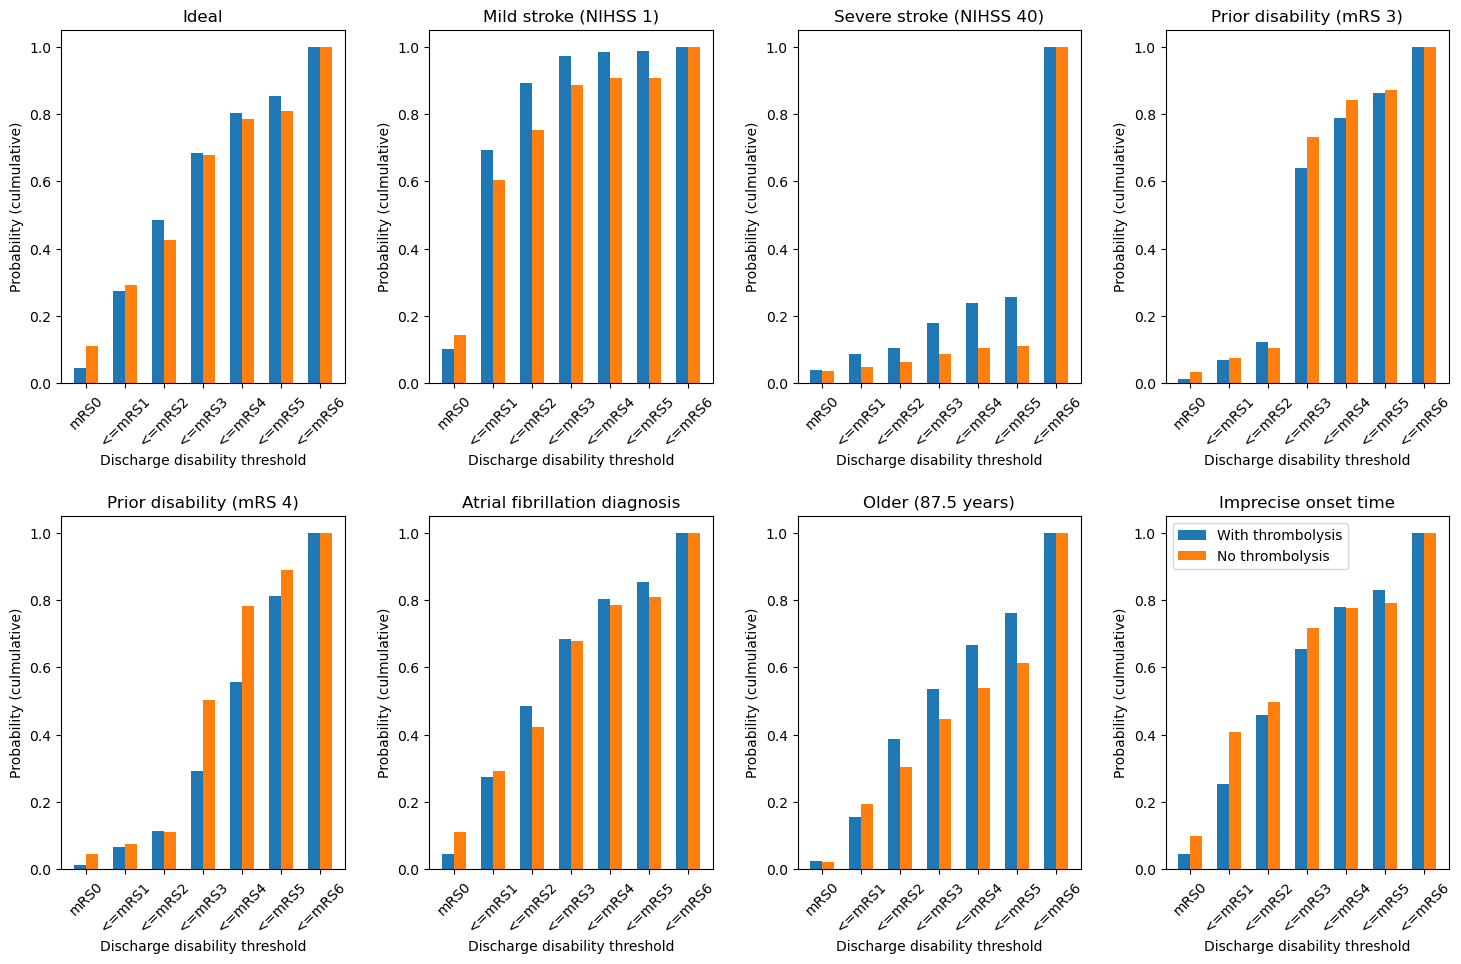

In [29]:
list_get_treatment = ["With thrombolysis","No thrombolysis"]
list_onset_to_thrombolysis_time = [ott_default, -100]

columns=["mRS0","<=mRS1","<=mRS2","<=mRS3","<=mRS4","<=mRS5","<=mRS6"]
index=["with","without"]

# Position of bars on x-axis
ind = np.arange(len(columns))

width = 0.3

fig = plt.figure(figsize=(15, 10))

for patient_loc in range(n_patients):
#    title = df_patient_prototypes.index.values[patient_loc]
    title = df_patient_prototypes.index[patient_loc]
    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), 
                                      index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[patient_loc,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[patient_loc,:]

    # make first copy have, and the second copy not have thrombolysis treatment 
    # (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = (
                                            list_onset_to_thrombolysis_time)

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)

    df_patient_mrs_results = pd.DataFrame(data=y_probs, columns=columns, 
                                          index=index)

    df_patient_mrs_results = df_patient_mrs_results.T

    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

    ax1 = fig.add_subplot(2,4,patient_loc+1)
    # Plotting
    mask = df_bar["Treatment"] == list_get_treatment[0]
    cumsum = np.cumsum(df_bar[mask]["Probability"].values)
    ax1.bar(ind, cumsum, width, 
            label=list_get_treatment[0])
    
    mask = df_bar["Treatment"] == list_get_treatment[1]
    cumsum = np.cumsum(df_bar[mask]["Probability"].values)
    ax1.bar(ind + width, cumsum, width, 
            label=list_get_treatment[1])

    plt.xlabel("Discharge disability threshold")
    plt.ylabel("Probability (culmulative)")
    plt.title(title)
    plt.xticks(ind + width / 2, columns, rotation=45)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout(pad=2)


filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_cumsum_bar_plot.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

Duration to run notebook

In [ ]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:02.591095'